In [49]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [50]:
# # download kaggle dataset
# !kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset


In [4]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import torch

In [52]:
# !unzip alzheimer-mri-dataset.zip
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [53]:
# convert images into a dataframe

images = []
labels = []
for subfolder in tqdm(os.listdir('Dataset')):
    subfolder_path = os.path.join('Dataset', subfolder)
    for image_filename in os.listdir(subfolder_path):
          image_path = os.path.join(subfolder_path, image_filename)
          images.append(image_path)
          labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 4/4 [00:00<00:00, 125.98it/s]


,image,label
0,Dataset\Mild_Demented\mild.jpg,Mild_Demented
1,Dataset\Mild_Demented\mild_10.jpg,Mild_Demented
2,Dataset\Mild_Demented\mild_100.jpg,Mild_Demented
3,Dataset\Mild_Demented\mild_101.jpg,Mild_Demented
4,Dataset\Mild_Demented\mild_102.jpg,Mild_Demented
...,...,...
6395,Dataset\Very_Mild_Demented\verymild_995.jpg,Very_Mild_Demented
6396,Dataset\Very_Mild_Demented\verymild_996.jpg,Very_Mild_Demented
6397,Dataset\Very_Mild_Demented\verymild_997.jpg,Very_Mild_Demented
6398,Dataset\Very_Mild_Demented\verymild_998.jpg,Very_Mild_Demented


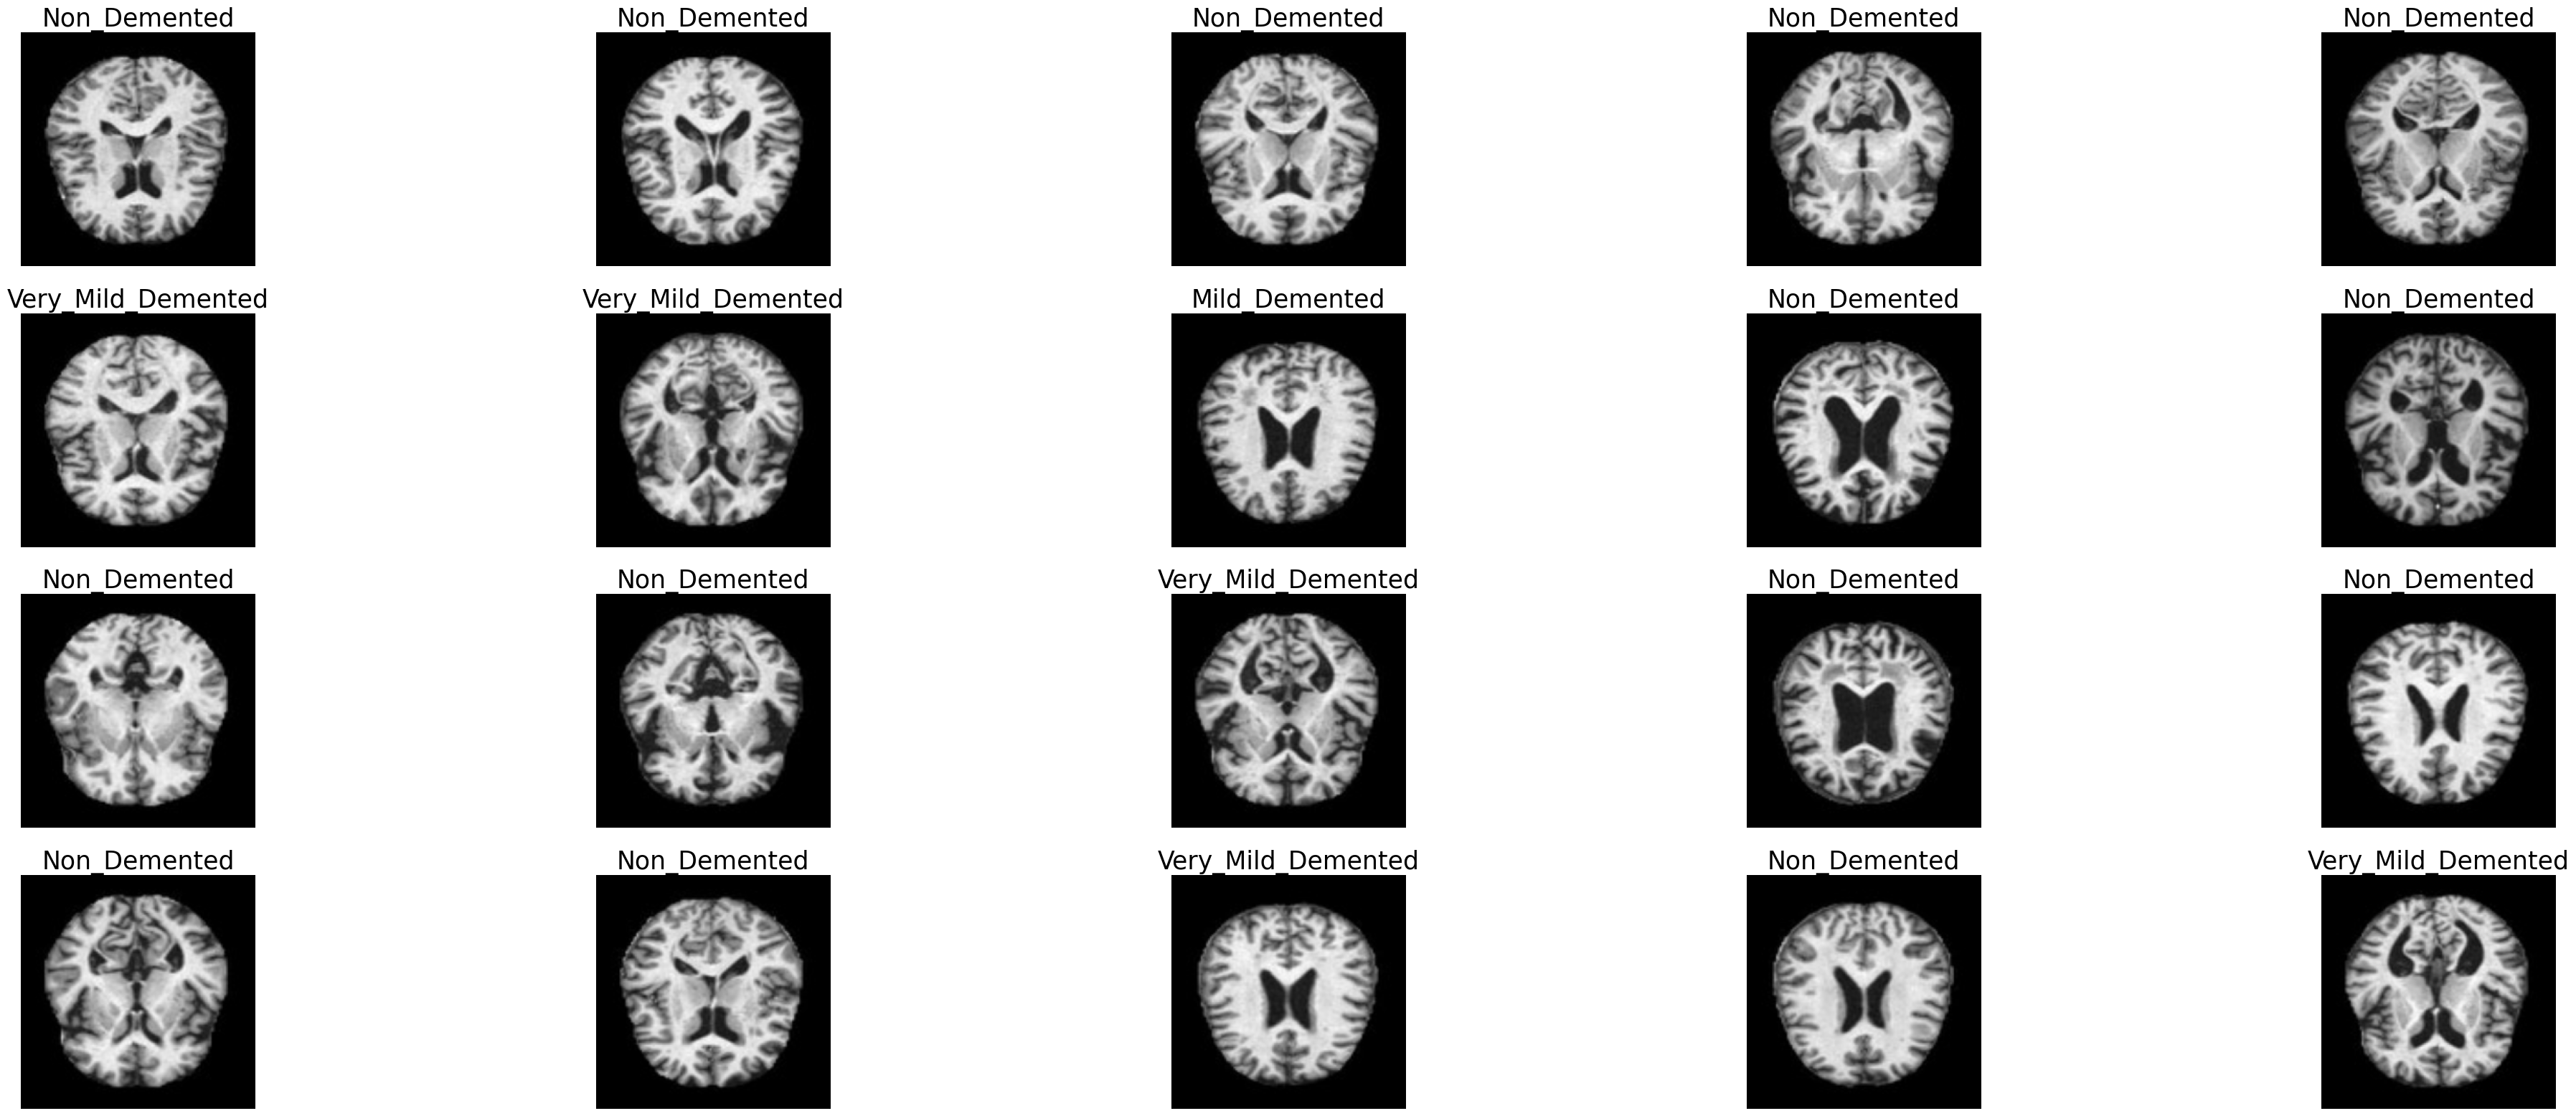

In [54]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

<Axes: xlabel='label', ylabel='count'>

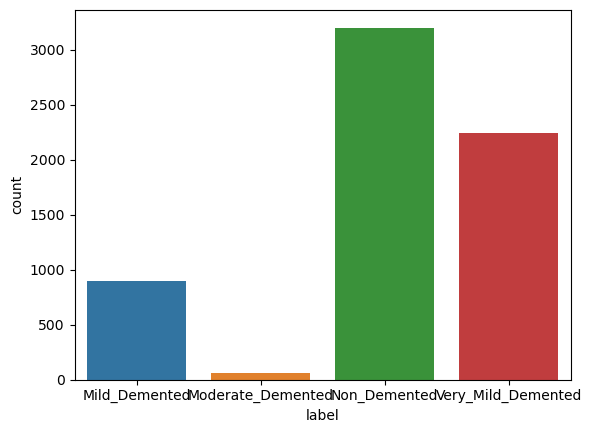

In [55]:
# data distribution
sns.countplot(df, x='label')

In [5]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn
from numpy import bincount

# Use GPU if available, else use CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

In [57]:
class AlzheimersDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.df = None
      self.transforms= None

    def set_df(self, df, transforms):
      self.df = df
      self.transforms = transforms

    def test_print(self):
      print(self.df.head())

    def __getitem__(self, index):
      img=cv2.imread(self.df.image[index])
      img=cv2.resize(img,(224,224))
      img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      label = self.df.label[index]
      # plt.imshow(img)
      # print(type(img), type(label))
      outimg = self.transforms(img)
      return outimg, label

    def __len__(self):
      return len(self.df)
        # raise NotImplementedError

In [58]:
di = {'Non_Demented':0, 'Very_Mild_Demented':1, 'Mild_Demented':2, 'Moderate_Demented':3}
di_list = ['Non_Demented','Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']

df = df.replace({"label": di})

transform_data = Compose([ToTensor(),
                          Resize(28),
                          Normalize((0.1307,), (0.3081,))])

In [59]:
# balanced sampler
def ws(df_col):
  counts = bincount(df_col)
  labels_weights = 1. / counts
  list(zip(range(4), counts))
  weights = labels_weights[df_col]
  ws = WeightedRandomSampler(weights, len(weights), replacement=True)
  return ws

In [60]:
# az_dataset = AlzheimersDataset()
# az_dataset.set_df(df, transform_data)
df = df.sample(frac=1).reset_index(drop=True)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

az_dataset_train = AlzheimersDataset()
az_dataset_train.set_df(df[:train_size], transform_data)
az_dataset_train.test_print()

df_test = df[train_size:]
df_test.reset_index(drop=True, inplace=True)
az_dataset_test = AlzheimersDataset()
az_dataset_test.set_df(df_test, transform_data)
az_dataset_test.test_print()



                               image  label
0  Dataset\Non_Demented\non_3063.jpg      0
1  Dataset\Non_Demented\non_2216.jpg      0
2  Dataset\Non_Demented\non_2946.jpg      0
3  Dataset\Non_Demented\non_2492.jpg      0
4  Dataset\Non_Demented\non_1306.jpg      0
                                         image  label
0            Dataset\Non_Demented\non_2022.jpg      0
1            Dataset\Non_Demented\non_3189.jpg      0
2            Dataset\Non_Demented\non_3012.jpg      0
3  Dataset\Very_Mild_Demented\verymild_525.jpg      1
4             Dataset\Non_Demented\non_685.jpg      0


In [61]:
# torch.random.manual_seed(42)
# train_size = int(0.8 * len(az_dataset))
# test_size = len(az_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(az_dataset, [train_size, test_size])

# print(type(az_dataset))
# print(type(train_dataset))

ws_train = ws(df[:train_size]['label'])
ws_test = ws(df[train_size:]['label'])

batch_size=128
az_dataloader_train = DataLoader(az_dataset_train, sampler=ws_train, batch_size=batch_size)
az_dataloader_test = DataLoader(az_dataset_test, sampler=ws_test, batch_size=batch_size)
print(len(az_dataset_train), len(az_dataloader_train))
print(len(az_dataset_test), len(az_dataloader_test))
# az_dataloader = DataLoader(az_dataset, sampler=ws, batch_size=batch_size)

5120 40
1280 10


c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<Axes: ylabel='count'>

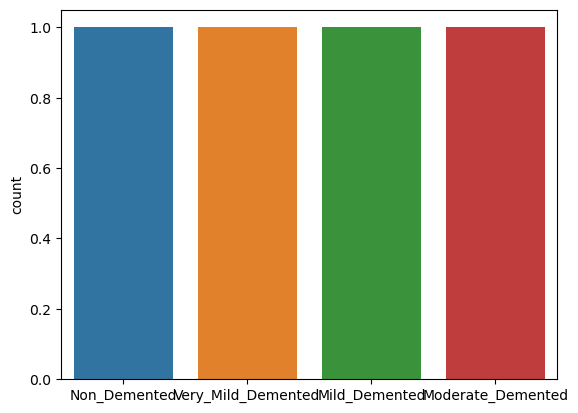

In [62]:
# more balanced mapping
for itered in az_dataloader_train:
  imgs, labels = itered
  break
# train, labels = next(iter(az_dataloader_train))
out=[di_list[i] for i in labels.numpy() ]
# print(di_list)
sns.countplot(pd.DataFrame(out),x=di_list)

In [63]:
print(imgs.shape)

torch.Size([128, 3, 28, 28])


In [64]:
import torch.optim as optim

def train(model, train_loader, test_loader, epochs = 10, lr = 0.001):
    # Use Adam optimizer to update model weights
    optimizer = optim.Adam(model.parameters(), lr = lr)
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Performance curves data
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs
            labels = labels
            # Zero out gradients
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            # Backpropagate loss and update model weights
            loss.backward()
            optimizer.step()
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')

        # Set model to evaluation mode
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs
            labels = labels
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')

    return train_losses, train_accuracies, test_losses, test_accuracies

# Standard CNN implementation

In [7]:
# standard convolution model
class Az_CNN(nn.Module):
  def __init__(self):
    super(Az_CNN, self).__init__()
    # two convolutional layers
    self.conv1 = nn.Conv2d(3,32, kernel_size=3, stride=1, padding=1 )
    self.conv2 = nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1)

    # two fully connected layers
    self.fc1 = nn.Linear(28*28*64, 128) # 224*224*3 = 50176 # [128, 224, 224, 3]
    self.fc2 = nn.Linear(128, 4)

  def forward(self, x):
      # Display initial shape
      # print("Initial: ", x.shape)

      # Pass input through first convolutional layer
      x = self.conv1(x)
      x = F.relu(x)
      # print("After conv1: ", x.shape)

      # Pass output of first conv layer through
      # second convolutional layer
      x = self.conv2(x)
      x = F.relu(x)
      # print("After conv2: ", x.shape)

      # Flatten output of second conv layer
      x = x.view(-1, 28*28*64)
      # print("After flatten: ", x.shape)

      # Pass flattened output through first Linear layer
      x = self.fc1(x)
      x = F.relu(x)
      # print("After FC1: ", x.shape)

      # Pass output of first Linear layer to second linear layer
      x = self.fc2(x)
      # print("After FC2: ", x.shape)
      return x


In [66]:
model = Az_CNN()
# model.load_state_dict(torch.load('Az_CNN_.pt'))
model.eval()
print(model.modules)

<bound method Module.modules of Az_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)>


In [67]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     az_dataloader_train, \
                                                                     az_dataloader_test, \
                                                                     epochs = 3, \
                                                                     lr = 1e-3)

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/3, Batch number: 0, Cumulated accuracy: 0.203125
Epoch 1/3, Batch number: 1, Cumulated accuracy: 0.26171875
Epoch 1/3, Batch number: 2, Cumulated accuracy: 0.2630208333333333
Epoch 1/3, Batch number: 3, Cumulated accuracy: 0.26953125
Epoch 1/3, Batch number: 4, Cumulated accuracy: 0.2625
Epoch 1/3, Batch number: 5, Cumulated accuracy: 0.2604166666666667
Epoch 1/3, Batch number: 6, Cumulated accuracy: 0.26004464285714285
Epoch 1/3, Batch number: 7, Cumulated accuracy: 0.263671875
Epoch 1/3, Batch number: 8, Cumulated accuracy: 0.265625
Epoch 1/3, Batch number: 9, Cumulated accuracy: 0.26640625
Epoch 1/3, Batch number: 10, Cumulated accuracy: 0.2677556818181818
Epoch 1/3, Batch number: 11, Cumulated accuracy: 0.267578125
Epoch 1/3, Batch number: 12, Cumulated accuracy: 0.26802884615384615
Epoch 1/3, Batch number: 13, Cumulated accuracy: 0.28125
Epoch 1/3, Batch number: 14, Cumulated accuracy: 0.27760416666666665
Epoch 1/3, Batch number: 15, Cumulated accuracy: 0.28466796875
Epoch

**Test loss: 0.7186, Test accuracy: 0.7063**

Goal: bring accuracy up, bring test loss down

1. To bring accuracy up: increase resolution, increase training epoch
2. To bring test loss down: use feature engineering

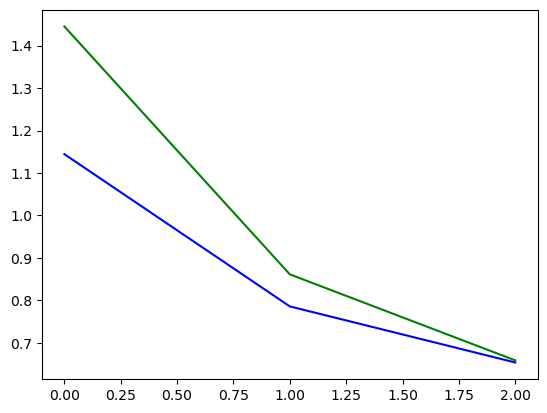

In [68]:
plt.plot(range(len(train_losses)), train_losses, 'g-', range(len(test_losses)), test_losses, 'b-')
# train_losses, train_accuracies, test_losses, test_accuracies

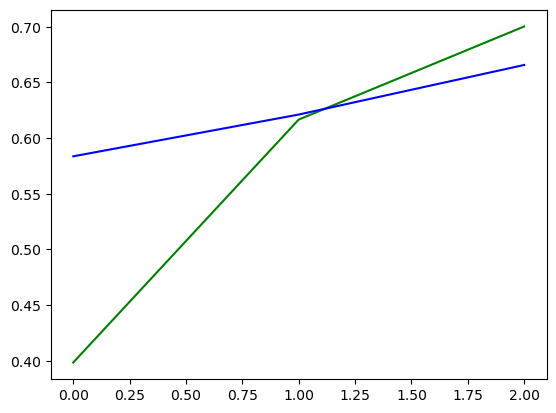

In [69]:
plt.plot(range(len(train_accuracies)), train_accuracies, 'g-', range(len(test_accuracies)), test_accuracies, 'b-')

In [86]:
model = Az_CNN() # for consistency with the other model below
# It really just requires more iterations and possible feature engineering
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     az_dataloader_train, \
                                                                     az_dataloader_test, \
                                                                     epochs = 10, \
                                                                     lr = 5e-4)

c:\Users\chong\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/10, Batch number: 0, Cumulated accuracy: 0.25
Epoch 1/10, Batch number: 1, Cumulated accuracy: 0.2734375
Epoch 1/10, Batch number: 2, Cumulated accuracy: 0.2916666666666667
Epoch 1/10, Batch number: 3, Cumulated accuracy: 0.298828125
Epoch 1/10, Batch number: 4, Cumulated accuracy: 0.2828125
Epoch 1/10, Batch number: 5, Cumulated accuracy: 0.27734375
Epoch 1/10, Batch number: 6, Cumulated accuracy: 0.27566964285714285
Epoch 1/10, Batch number: 7, Cumulated accuracy: 0.2724609375
Epoch 1/10, Batch number: 8, Cumulated accuracy: 0.2664930555555556
Epoch 1/10, Batch number: 9, Cumulated accuracy: 0.2875
Epoch 1/10, Batch number: 10, Cumulated accuracy: 0.28125
Epoch 1/10, Batch number: 11, Cumulated accuracy: 0.2838541666666667
Epoch 1/10, Batch number: 12, Cumulated accuracy: 0.2842548076923077
Epoch 1/10, Batch number: 13, Cumulated accuracy: 0.2806919642857143
Epoch 1/10, Batch number: 14, Cumulated accuracy: 0.27708333333333335
Epoch 1/10, Batch number: 15, Cumulated accuracy:

In [87]:
# Save model
torch.save(model.state_dict(), 'Az_CNN_5e_4.pt')

With 13 epochs, the model achieves

- **Train loss: 0.2254, Train accuracy: 0.9129**
- **Test loss: 0.2266, Test accuracy: 0.9094**

It is still not overfitting and can take more epochs.

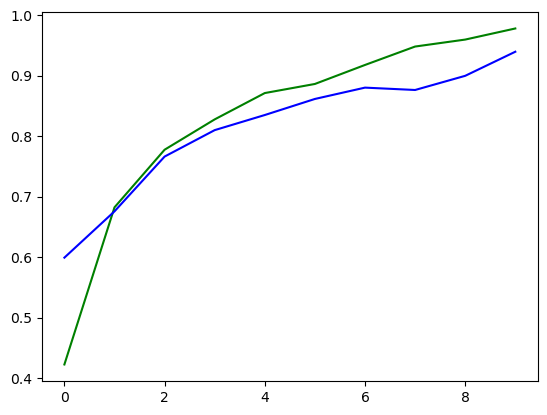

In [88]:
plt.plot(range(len(train_accuracies)), train_accuracies, 'g-', range(len(test_accuracies)), test_accuracies, 'b-')

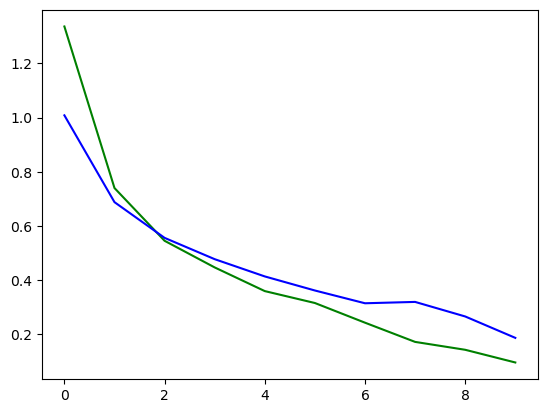

In [89]:
plt.plot(range(len(train_losses)), train_losses, 'g-', range(len(test_losses)), test_losses, 'b-')


In [ ]:
model = Az_CNN()
# model.load_state_dict(torch.load('Az_CNN_2.pt'))
model.eval()
print(model.modules)
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     az_dataloader_train, \
                                                                     az_dataloader_test, \
                                                                     epochs = 10, \
                                                                     lr = 1e-4)

Compared to the without these changes, we see a decrease in loss and increase in test accuracy. However it is not very significant and requires further fine tuning.

**Std CNN:**
- Test loss: 0.7186,
- Test accuracy: 0.7063

**Edited CNN:**
- Test loss: 0.6057,
- Test accuracy: 0.7156

In [93]:
# Save model
torch.save(model.state_dict(), 'Az_CNN_1e_4.pt')